In [3]:
import pandas as pd
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE

## 讀取檔案

In [4]:
train = pd.read_csv('./train.csv')
train.drop(columns = ['Id'], inplace = True)
print(train.shape)
train

(1095, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,60.0,21930,Pave,NaN,IR3,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,192140
1,60,RL,68.0,10769,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,212000
2,120,RL,34.0,4590,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,209500
3,50,RM,60.0,9600,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,NaN,GdWo,NaN,0,7,2007,WD,Normal,125000
4,80,RL,94.0,7819,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Abnorml,107000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,70,RL,51.0,9842,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,189000
1091,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
1092,20,FV,60.0,7200,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2006,New,Partial,187750
1093,20,RL,88.0,10994,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,9,2009,COD,Abnorml,257000


## 取出連續型特徵 (方便降維)

In [5]:
continual = train.columns[~(train.dtypes == 'object')]
df = train[continual]
print(df.shape)

(1095, 37)


## 分析缺失值

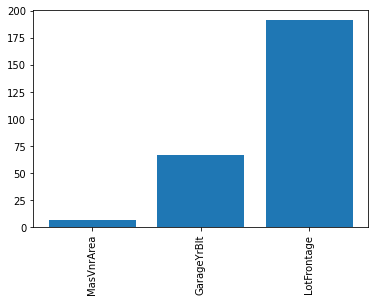

In [6]:
missing = df.isnull().sum(axis = 0)
missing = missing[missing > 0]
missing.sort_values(inplace=True)

plt.bar(list(missing.index), np.array(missing))
plt.xticks(rotation='vertical')
plt.show()

## 去除缺失值

In [7]:
df = df.dropna()
print(df.shape)

(838, 37)


## 轉化成 ndarray 後進行標準化，並將 Y 透過四分位數轉換成四個類別

In [9]:
target = 'SalePrice'
X = np.asarray(df.drop(columns = [target]))
Y = np.asarray(df[target])

# 將 Y 依照四分位距分成四類
Y = pd.qcut(Y, 4, labels = False)

# 將 X 標準化
X = (X - X.mean(axis = 0)) / X.std(axis = 0)

print(X.shape, Y.shape)

(838, 36) (838,)


## 利用 TSNE 降維

In [10]:
tsne = TSNE(
    n_components=2, init='pca', perplexity = 40, 
    early_exaggeration = 8, learning_rate = 150,
    n_iter = 2000
)
X_tsne = tsne.fit_transform(X)

## 做圖

In [14]:
df_tsne = pd.DataFrame()
df_tsne['X_tsne1'] = X_tsne[:, 0]
df_tsne['X_tsne2'] = X_tsne[:, 1]
df_tsne['label'] = Y
df_tsne.head()

,X_tsne1,X_tsne2,label
0,6.945890,14.935214,2
1,12.313646,15.391663,2
2,17.631475,-12.355916,2
3,-26.266367,-6.174645,0
4,-8.595237,3.409637,0


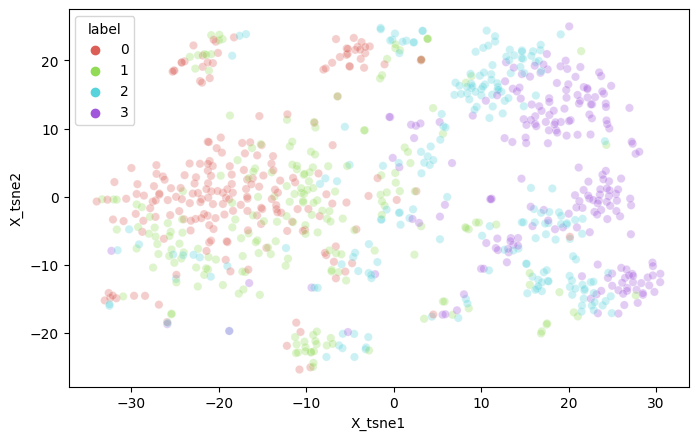

In [13]:
plt.figure(figsize = (8, 5), dpi = 100)
sns.scatterplot(
    x = 'X_tsne1', y = 'X_tsne2',
    hue = 'label', palette = sns.color_palette('hls', 4),
    data = df_tsne, legend = 'full',
    alpha = 0.3
)
plt.show()

## 1. 請問同學從降維後的圖表中可以看出什麼現象？
0, 1兩個類別重疊性高； 2, 3 兩個類別重疊性也高，但 01 跟 23 有較明顯的差距，故之後努力方向為將 01, 23 個別切分開來

## 2. 請同學分析，什麼因素導致降維後的點座標重合性高？
目前只使用連續型的特徵，尚未使用離散特徵，且只是單純的將具缺失值的資料刪除，故可以預期降維效果不佳